# Assignment 1 

In [1]:
import torch 
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print('device:', device)

n_epochs = 50
batch_size_train = 64
batch_size_test = 100
learning_rate = 0.01
momentum = 0.5
log_interval = 100 # how many batches to wait before logging training status

random_seed = 1
# cuDNN uses nondeterministic algorithms which can be disabled setting
# so we can make sure that the results are reproducible
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

device: mps


# Task 1 
- Load the MNIST dataset into train and test data loaders. 
- Use the same parameters and apply the same transformations like described in the blog post.

In [3]:
# Need DataLoaders for the dataset, which is where TorchVision comes in. 
# We use a batch_size of 64 for training and size 1000 for testing on this dataset. 

# download the training data 
train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('./files/', train=True, download=True, # set train to True to download the training data
                             transform=torchvision.transforms.Compose([ # define transformations to be applied to the data
                               torchvision.transforms.ToTensor(), # convert the data to tensors of PyTorch 
                               torchvision.transforms.Normalize( # normalize the data
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_train,  # setup the batch size
  shuffle=True) # randomly shuffle the data, increases the randomness of the data

# download the test data
test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('./files/', train=False, download=True, # set train to False to download the test data
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_test, 
  shuffle=True)


100%|██████████| 9912422/9912422 [00:01<00:00, 8894077.31it/s] 


Extracting ./files/MNIST/raw/train-images-idx3-ubyte.gz to ./files/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 53505165.12it/s]


Extracting ./files/MNIST/raw/train-labels-idx1-ubyte.gz to ./files/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 20505868.98it/s]


Extracting ./files/MNIST/raw/t10k-images-idx3-ubyte.gz to ./files/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 8750817.07it/s]

Extracting ./files/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./files/MNIST/raw



# Task 2 
- Create a feedforward neural network with same structure as in 0_Simple_NN.py 
  -  an input layer, 
  -  one hidden layer with 100 neurons 
  -  and an output layer
-  You need to change the following:
   -  Adjust the size of the input layer to the size of the MNIST images (28x28)
   -  Use log_softmax as activation function for the output layer

In [174]:
class TwoLayerNet(nn.Module):
    def __init__(self, D_in, H, D_out):
        """
        In the constructor we instantiate two nn.Linear modules and assign them as member variables.
        """
        super(TwoLayerNet, self).__init__()
        # the weight and bias of linear1 will be initialized 
        # you can access them by self.linear1.weight and self.linear1.bias
        self.linear1 = nn.Linear(D_in, H, device) # this will create weight, bias for linear1
        self.linear2 = nn.Linear(H, D_out, device) # this will create weight, bias for linear2

    def forward(self, x):
        """
        In the forward function we accept a Tensor of input data and we must return a Tensor of output data.
        We can use Modules defined in the constructor as well as arbitrary operators on Tensors.
        """
        x.to(device) # move the data to the device (cpu or gpu)
        h_relu = F.relu(self.linear1(x))
        y_pred = F.log_softmax(self.linear2(h_relu), dim=1)
        return y_pred

In [175]:
# N is batch size; 
# D_in is input dimension, which is 28*28, because the image is 28*28 pixels;
# H is hidden dimension (Only one hidden layer, but containing 100 neurons.); 
# D_out is output dimension

# Now let's initialize the network and the optimizer.
network = TwoLayerNet(D_in = 784, H=100, D_out=10)
optimizer = optim.SGD(network.parameters(), 
                      lr=learning_rate,
                      momentum=momentum)


# Task 3 
- Train your network on the training data for 50 epochs using the negative log likelihood loss (F.nll_loss)
- Create a plot of training loss (but without the test loss). 
  
# Task 4
- Test the network on the MNIST test data and give out accuracy and loss. 

In [176]:
train_losses = [] # Save the loss value of each training loop (epoch) of the neural network model during the training process
train_counter = [] # Save the number of images for training so far
test_losses = [] # Save the loss value of each test loop (epoch) of the neural network model during the training process
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs)] # how many images for training so far

In [178]:
def train(epoch):
    network.train() # set the network to training mode
    correct = 0 # the number of correct predictions

    for batch_idx, (data, target) in enumerate(train_loader):
        # batch_idx:will get 0, 1, 2, 3... in order, used to indicate which batch of the dataset is currently being processed
        # data: the images in the current batch, target: the labels of the images in the current batch
        # (data, tartget) is a tuple, which convenience to process the data and target at the same time
        optimizer.zero_grad()
        data = data.view(data.size(0), -1) # reshape the data to be a vector of 784 elements (28*28)

        # move the data to the device (cpu or gpu)
        data.to(device)
        target.to(device)

        # forward propagation
        output = network(data)
        loss = F.nll_loss(output, target)

        # calculate the number of correct predictions
        pred = output.data.max(1, keepdim=True)[1]
        correct += pred.eq(target.data.view_as(pred)).sum()

        # backward propagation
        loss.backward() 
        optimizer.step()

        # in order to not print out every single batch, we use log_interval to print out the loss value every log_interval batches
        if batch_idx % log_interval == 0: # print when batch_idx is 640, 1280, 1920 ...
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}, Accuracy: {}/{} ({:.0f}%)'.format(
                epoch, 
                batch_idx * len(data), 
                len(train_loader.dataset),
                100. * batch_idx / len(train_loader), 
                loss.item(),
                correct, len(train_loader.dataset), # correct is the number of correct predictions
                100. * correct / len(train_loader.dataset)
                )) # loss.item() is the loss value of the current batch
            
            train_losses.append(loss.item())
            train_counter.append(
                (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
            
            # Save the model and optimizer parameters (their internal state), so we can continue training from previously saved state if needed.
            # We'd just need to call .load_state_dict(torch.load(PATH)) to load the state.
            torch.save(network.state_dict(), './results/model.pth') # save the model
            torch.save(optimizer.state_dict(), './results/optimizer.pth') # save the optimizer

In [179]:
def test():
    network.eval() # set the network to evaluation mode
    test_loss = 0 # the loss value of the current test loop (epoch)
    correct = 0 # the number of correct predictions
    with torch.no_grad():
        for data, target in test_loader: # loop over the test data
            data = data.view(-1, 784) # reshape the data to be a vector of 784 elements (28*28)
            output = network(data) # put the data into the network to get the output
            test_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss
            # output is a tensor of shape (batch_size, 10), which contains the log-probability of each class
            # we use .data.max(1m keepdim=True)[1] to get the index of the max log-probability, [1] means the index of the max log-probability rather than the max log-probability itself
            pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
            # pred is a tensor of shape (batch_size, 1), which contains the index of the max log-probability
            # target is a tensor of shape (batch_size), which contains the ground truth label of the image
            # pred.eq(target.data.view_as(pred)) return a boolean tensor, and we use .sum() to get the number of correct predictions 'True' in the boolean tensor
            correct += pred.eq(target.data.view_as(pred)).sum()
    test_loss /= len(test_loader.dataset) # get the average loss value of the current test loop (epoch)
    test_losses.append(test_loss) # save the loss value of the current test loop (epoch)
    print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset), # correct is the number of correct predictions
        100. * correct / len(test_loader.dataset))) # calculate the accuracy


In [180]:
print('device:', device)

for epoch in range(1, n_epochs + 1):
    train(epoch)
    test()

device: mps
Train Epoch: 1 [0/60000 (0%)]	Loss: 2.395514, Accuracy: 8/60000 (0%)


Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.600250, Accuracy: 4461/60000 (7%)
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.436474, Accuracy: 9983/60000 (17%)
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.481911, Accuracy: 15703/60000 (26%)
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.380317, Accuracy: 21418/60000 (36%)
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.129691, Accuracy: 27188/60000 (45%)
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.223789, Accuracy: 33012/60000 (55%)
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.351787, Accuracy: 38829/60000 (65%)
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.279547, Accuracy: 44658/60000 (74%)
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.538881, Accuracy: 50556/60000 (84%)

Test set: Avg. loss: 0.2673, Accuracy: 9247/10000 (92%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.284558, Accuracy: 59/60000 (0%)
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.249058, Accuracy: 5924/60000 (10%)
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.209405, Accuracy: 11865/60000 (20%)
Train Epo

Text(0, 0.5, 'negative log likelihood loss (losses)')

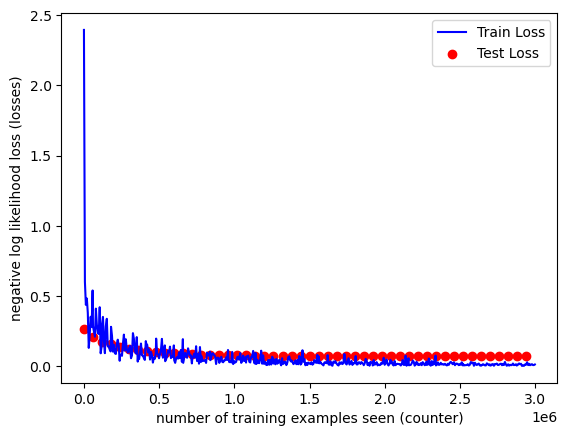

In [181]:
import matplotlib.pyplot as plt
plt.plot(train_counter, train_losses, color='blue')
plt.scatter(test_counter, test_losses, color='red')
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('number of training examples seen (counter)')
plt.ylabel('negative log likelihood loss (losses)')

# Task 5 
- Find out how the model can be trained on the GPU instead of the CPU. 
- Compare the training time between CPU and GPU. 

In [182]:
# using cpu to train the model
# current time 
import time
device = torch.device("cpu") # set the device to be cpu
print('device:', device)
start_time = time.time()
train(1)
time_cpu = time.time()
print ("CPU time: ", time_cpu - start_time)

# using gpu to train the model
device = torch.device("mps") # set the device to be MPS for mac os 
print('device:', device)
start_time = time.time()
train(1)
time_gpu = time.time()

# compare the time difference
print ("GPU time: ", time_gpu - start_time)

device: cpu
Train Epoch: 1 [0/60000 (0%)]	Loss: 0.004993, Accuracy: 64/60000 (0%)
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.004429, Accuracy: 6461/60000 (11%)
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.006418, Accuracy: 12852/60000 (21%)
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.013496, Accuracy: 19245/60000 (32%)
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.006464, Accuracy: 25638/60000 (43%)
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.037968, Accuracy: 32030/60000 (53%)
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.012816, Accuracy: 38426/60000 (64%)
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.022538, Accuracy: 44821/60000 (75%)
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.006768, Accuracy: 51217/60000 (85%)
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.009617, Accuracy: 57610/60000 (96%)
CPU time:  4.664626121520996
device: mps
Train Epoch: 1 [0/60000 (0%)]	Loss: 0.006593, Accuracy: 64/60000 (0%)
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.013708, Accuracy: 6463/60000 (11%)
Train Epoch: 1 [12800